# MIMIC-III Sepsis Feature Probe

There are many possible features and markers that could indicate the survivability of a patient with suspected sepsis. In this notebook I will probe and visualize the suspected features of import. I will conduct several techniques to select features and trim less significant ones using univariate analysis and other techniques.

Note that the dataset in its entirety has been set up locally on a Postgresql database. All machine learning will be done remotely to save time and resources down the road.

In [1]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import datetime

import seaborn as sns
sns.set(style='ticks')

%matplotlib inline

In [73]:
# Set up SQL Alchemy engine and session
Base = automap_base()

# Doing basic probes on data locally
engine = create_engine("postgresql://mimic_user@localhost:5432/mimic")

# Reflect the tables
Base.prepare(engine, reflect=True, schema='mimiciii')

# mapped classes are now created with names by default
# matching that of the table name.
Admission = Base.classes.admissions
Patient = Base.classes.patients
LabEvent = Base.classes.labevents
BioEvent = Base.classes.microbiologyevents

session = Session(engine)

In [3]:
# session.query(User.name.label('name_label')).all()
# admission_query = session.query(Admission)
admission_query = session.query(Admission).filter_by(diagnosis='SEPSIS')
#  User.query.filter_by(username='peter').first()
df = pd.read_sql(admission_query.statement, admission_query.session.bind)

df.head()
# admission_type, hospital_expire_flag

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1
1,471,366,134462,2164-11-18 20:27:00,2164-11-22 15:18:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,SINGLE,HISPANIC OR LATINO,2164-11-18 10:52:00,2164-11-18 21:31:00,SEPSIS,0,1
2,96,94,183686,2176-02-25 16:49:00,2176-02-29 17:45:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,CANT,NOT SPECIFIED,MARRIED,ASIAN,2176-02-25 10:35:00,2176-02-25 18:14:00,SEPSIS,0,1
3,20,21,111970,2135-01-30 20:50:00,2135-02-08 02:08:00,2135-02-08 02:08:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,JEWISH,MARRIED,WHITE,2135-01-30 18:46:00,2135-01-30 22:05:00,SEPSIS,1,1
4,448,353,108923,2151-03-28 16:01:00,2151-04-13 16:10:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,PTUN,JEWISH,SINGLE,WHITE,2151-03-28 13:02:00,2151-03-28 17:46:00,SEPSIS,0,1


In [4]:
def period(row, period):
    
    if row['deathtime'] == None:
        return 0
    elif row['deathtime'] - row['admittime'] > period:
        return 0
    else:
        return 1
    row['admittime']

In [5]:
df['death_period'] = df.apply (lambda row: period (row, pd.Timedelta('30 days')),axis=1)

In [6]:
adm_col = ['subject_id', 'hadm_id', 'admittime', 'admission_type', 'insurance', 'ethnicity', 'death_period']
admissions = df[adm_col]

In [7]:
# Obtain patient information and trim unnecessary information
patient_query = session.query(Patient)
patients = pd.read_sql(patient_query.statement, patient_query.session.bind)
patients = patients[['subject_id', 'gender', 'dob']]

In [8]:
# Join patients and admission dataframes to obtain gender and age of patient
patient_info = admissions.join(patients.set_index('subject_id'), on='subject_id')

In [9]:
def age(row):
    possible_age = int((row['admittime'] - row['dob'])/pd.Timedelta('365 days'))
    # For those holder than 89, their ages have been removed and set to 300 years prior to admission.     
    if possible_age < 0:
        # 91.4 is the median age for those with removed ages. This is what we will set all ages to that are older than 89       
        possible_age = 91
    return possible_age

In [10]:
patient_info['age'] = patient_info.apply (lambda row: age (row),axis=1)

In [11]:
patient_info.head()

,subject_id,hadm_id,admittime,admission_type,insurance,ethnicity,death_period,gender,dob,age
0,357,122609,2198-11-01 22:36:00,EMERGENCY,Private,WHITE,0,M,2135-03-22,63
1,366,134462,2164-11-18 20:27:00,EMERGENCY,Medicare,HISPANIC OR LATINO,0,M,2112-05-22,52
2,94,183686,2176-02-25 16:49:00,EMERGENCY,Medicare,ASIAN,0,M,2101-09-20,74
3,21,111970,2135-01-30 20:50:00,EMERGENCY,Medicare,WHITE,1,M,2047-04-04,87
4,353,108923,2151-03-28 16:01:00,EMERGENCY,Medicare,WHITE,0,M,2089-07-23,61


## Analyzing the Importance of Basic Patient Information

The admission table has been trimmed and a period of importance for mortality computed. The patient information table has been trimmed and joined to the modified admission table. It is now possible to look into several different potentially useful details regarding patient mortality.

In [12]:
patient_info.describe()

,subject_id,hadm_id,death_period,age
count,1184.000000,1184.000000,1184.000000,1184.000000
mean,32912.771115,149545.354730,0.212838,66.583615
std,28172.426424,29131.331324,0.409487,16.538276
min,21.000000,100262.000000,0.000000,0.000000
25%,10827.500000,123816.000000,0.000000,56.000000
50%,23820.500000,149640.500000,0.000000,68.000000
75%,50275.500000,175462.000000,0.000000,80.000000
max,99973.000000,199880.000000,1.000000,91.000000


In [13]:
pos = patient_info[patient_info['death_period'] == 0]
neg = patient_info[patient_info['death_period'] == 1]
print pos.shape
print neg.shape

(932, 10)
(252, 10)


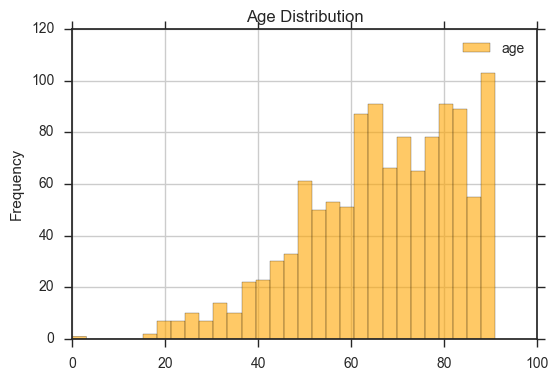

In [14]:
ax = patient_info[['age']].plot(kind='hist', title ="Age Distribution", legend=True, grid=True, bins=30, color='orange', alpha=0.6)

### Data Overview
A trend can be seen in the age of patients admitted with suspected sepsis. As age increases, the risk of sepsis also increases somewhat linearly. It is important to note that the large number of patients at 92 years old is due to a HIPAA compliency that removes exact ages of those older than 89. The median value is approximately 92 years of age, hence the large number in that bucket.

The mean age is ~67 years old with a standard deviation of ~17 years. This is another clear indication that sepsis is particularly relevant to those older than 56 years of age. 75% of the cases affect patients older than 56 years old.

#### Mortality 
There are a total of 1184 patients admitted with suspected sepsis. Of those admitted, 932 survived >30 days in the ICU. 256 did not survive 30 days after admittance. Therefore there is a 21% mortality rate of those admitted with suspected sepsis. Next let us break this down by age.

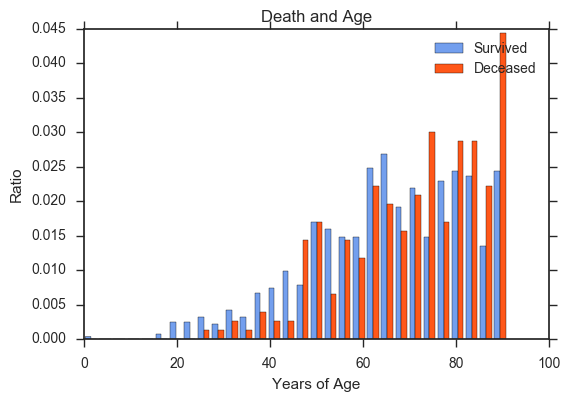

In [15]:
_ = plt.hist([pos['age'],neg['age']], bins=30, alpha=0.9, normed=True, label=['Survived','Deceased'], color=['cornflowerblue','orangered'])

plt.title('Death and Age')
plt.xlabel('Years of Age')
plt.ylabel('Ratio')
plt.legend(loc='upper right')

#### Age and Survivability
While there is no clear marker, around 50 years of age a switch from primarily surviving a septic condition with a probability >0.75 to primarily succuming to the condition. This, visually, suggests that age is particularly important in the survivaibility. There are likely other factors that are strongly correlated to age however.

### Gender and Survivability

Male Mortality: 0.29
Female Mortality: 0.247685185185


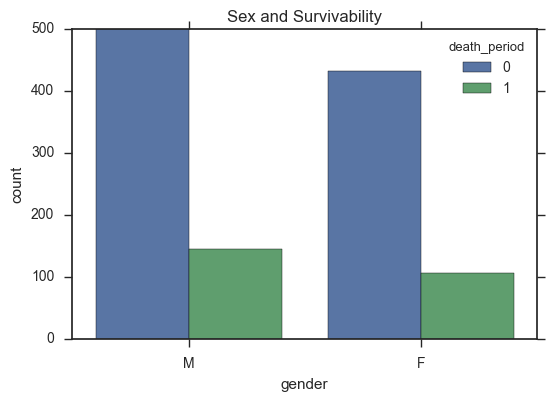

In [16]:
ax = plt.axes()
sns.countplot(x="gender", hue="death_period", data=patient_info, ax=ax)
ax.set_title('Sex and Survivability')
alive = pos.gender.value_counts()
dead = neg.gender.value_counts()
print "Male Mortality: {}".format(dead.M/float(alive.M))
print "Female Mortality: {}".format(dead.F/float(alive.F))

Gender does not appear to play a significant role on the survivability of sepsis, however, in conjunction with another feature it may add useful information. Male respitory rate may be lower than female respitory rate and may help shift the importance in a machine learning algorithm.

### Insurance Type and Survivability

Medicare Mortality: 0.3024
Medicaid Mortality: 0.27027027027
Private Mortality: 0.169014084507


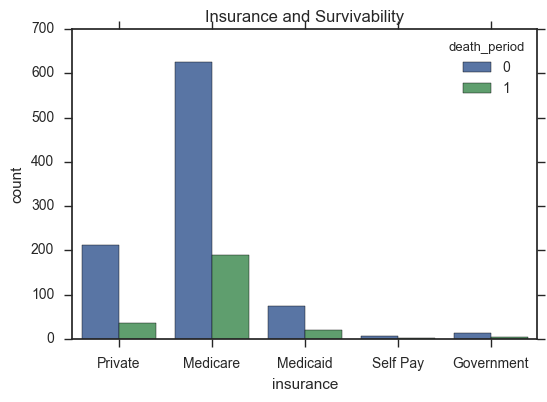

In [17]:
ax = plt.axes()
sns.countplot(x="insurance", hue="death_period", data=patient_info, ax=ax)
ax.set_title('Insurance and Survivability')

alive = pos.insurance.value_counts()
dead = neg.insurance.value_counts()
print "Medicare Mortality: {}".format(dead.Medicare/float(alive.Medicare))
print "Medicaid Mortality: {}".format(dead.Medicaid/float(alive.Medicaid))
print "Private Mortality: {}".format(dead.Private/float(alive.Private))


This breakdown of survivability by insurance type makes sense. Medicare is insurance administered by the US Government and fulfilled by private insurers for individuals 65 years and older. From the previous breakdown by age, we can see that those older than 65 are at an increased risk of succumbing to sepsis. Private insurance holders are likely younger. Therefore the descrepency in survivability is more understandable, 30% mortality rate for Medicare insurance holders and almost half that for private insurance holders at 17%.

The real question comes when we look at Medicaid mortality rates which are 27%. Medicaid is provided by the US Government to individuals that reside at or at 133% of the poverty line. What this is indicating is that income also plays a role on the survivability of a septic condition.

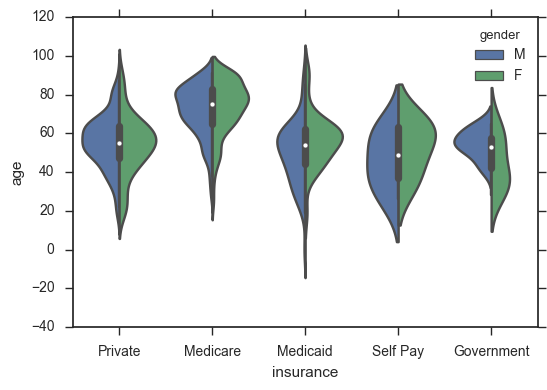

In [18]:
sns.violinplot(x="insurance", y="age", hue="gender", data=patient_info, split=True);

Here we can see a violin graph with age on the y-axis, insurance type on the x-axis, and Male represented by blue and Female by green. This clariefies the suspicion that Medicare holders are older on average. Medicaid and Private insurance holders appear to be approximately the same age on average. Self pay and government insurance have too few data points to draw any sort of conclusion. Gender also seems relatively balanced except for Medicaid insurance holders. More young men tend to have medicaid insurance than young women.

## Obtaining Vitals

The initial vitals, within 48 hours, will likely be the most useful information for predicting the survivability of a septic condition. Graphing and visualizing this data will allow us to make insights into which features are of higher importance and which are likely irrelevant and can be trimmed from the dataset.

In [19]:
vital_ids = {   
                50827: 'respiration', # respiration rate
                50912: 'creatinine',  # creatinine levels indicate kidney issues
                50813: 'lactate',     # lactate levels indicate shock and cellular anirobic respiration
                50889: 'CRP',         # C-reactive protein systemic inflammation
                51300: 'WBC',         # White blood cell count indicates systemic reaction to infection
                51006: 'BUN',         # Blood Urea Nitrogen indicates kidney issues
                51288: 'ESR',         # erythrocyte sedimentation rate another inflammation test
                51265: 'platelet',    # decreased platelet counts parallel the severity of infection
                50825: 'tempurature', # tempurature is highly indicative of infection and/or immune response
                50816: 'oxygen',
                51275: 'PT',
                51274: 'PTT',
                51277: 'RBCDW',       # red blood cell distribution width
                51256: 'neutrophils',
                50818: 'pco2',
                50821: 'po2',
                50893: 'calcium',
                50931: 'glucose',
                51221: 'hematocrit',
                51222: 'hemoglobin',
                51244: 'lymphocytes'
            } 

In [20]:
# Query database labevents for all information related to all hospital admission ids we are interested in 
# along with all item types we are interested in, defined above
patient_hadm_ids = patient_info.hadm_id.tolist()
# Beautiful query /sarcasm
lab_event_query = session.query(LabEvent).filter(LabEvent.hadm_id.in_(patient_hadm_ids)).filter(LabEvent.itemid.in_(vital_ids.keys()))

lab_events = pd.read_sql(lab_event_query.statement, lab_event_query.session.bind).groupby('hadm_id')

In [21]:
# Prepare joining copy of patient vitals
patient_vitals = patient_info[['hadm_id']].copy()
for value in vital_ids.values():
    patient_vitals[value] = np.nan
    
patient_vitals = patient_vitals.set_index('hadm_id')

In [22]:
# Respiration rate value needs to be cleaned. 
def clean_respiration(value):
    return max([int(x) for x in value.split('/') if x.isdigit()])

In [23]:
# Cycle through data, check for appropriate data within time period, average values and store
one_day = pd.Timedelta('1 days')
# Each hospital stay, think of it as an individual patient (though technically not true)
for hadm_id, group in lab_events:
    sub_groups = group.groupby('itemid')
    admittance_time = patient_info.loc[patient_info.hadm_id==hadm_id]['admittime'].values[0]
    # Each lab item type
    for lab_item, sub_group in sub_groups:
        day_results = sub_group[((sub_group.charttime - admittance_time) < one_day)]
        # Unfortunate special case: If dirty respitory rate value, clean         
        if lab_item == 50827:
            cleaned_resp = map(clean_respiration, day_results['value'])
            mean =  np.mean(cleaned_resp)
        else:
            mean = day_results['valuenum'].values.mean()
        patient_vitals.set_value(hadm_id, vital_ids[lab_item], mean)
    

/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
# Check which features are not worth considering due to lack of information
patient_vitals.isnull().sum()

creatinine        8
platelet          8
pco2            412
PT               72
WBC            1172
po2             412
CRP             993
PTT              68
respiration     951
lymphocytes      58
RBCDW            10
calcium          23
neutrophils      58
glucose           9
hematocrit        9
hemoglobin       10
tempurature     634
ESR            1120
oxygen          836
lactate          86
BUN               8
dtype: int64

I made the near-sighted assumption that most patients would have these vitals taken within the first day. It is possible some of these measurements, such as temperature, are recorded elsewhere in the database. For data within the lab events table, though, I will need to trim some of this data due to the lack of values. The few instances with no information will be filled in with the mean values. For the ML phase, I may need to trim some patients out that have no recorded values or died within the first day of entering the ICU.

In [25]:
# Vitals that will be kept. The rest dropped due to lack of data
keep_vitals = ['creatinine', 'platelet', 'PT', 'PTT', 'lymphocytes', 'RBCDW', 'calcium', 'neutrophils', 'glucose', 'hematocrit', 'hemoglobin', 'lactate', 'BUN']
patient_vitals_fixed = patient_vitals[keep_vitals]

In [26]:
# Replace NaN values with the mean of each column. In the actual ML phase it may be worth figuring out WHY
# Some values are missing. Here we will simply continue with mean.
patient_vitals_fixed = patient_vitals_fixed.fillna(patient_vitals.mean())

In [28]:
# New patient info dataframe finally with vitals
vital_patient_info = patient_info.join(patient_vitals_fixed, on='hadm_id')

# New pos and neg df for easy consideration of survival
pos = vital_patient_info[vital_patient_info['death_period'] == 0]
neg = vital_patient_info[vital_patient_info['death_period'] == 1]

## Visualize Patient Vitals

Now that we have gathered feasible patient vitals and it will be useful to see the distribution of such information and if there is any visual correlation between 30 day mortality and initial readings.

In [44]:
vital_columns = keep_vitals[:]
vital_columns.extend(['death_period', 'age'])

In [45]:
vitals_only = vital_patient_info[vital_columns]

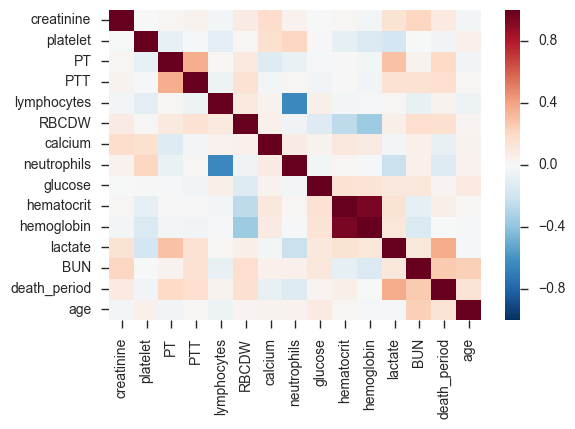

In [46]:
# Observe correlation of values
correlation_df = vitals_only.corr().copy()
sns.heatmap(correlation_df)

While this doesn't throw any obvious red flags in correlation, it is important to note that this is thousands of human bodies and results are varied with many factors playing a role. There are several interesting correlations that are unrelated to mortality. Lymphocytes and neutrophils are quite strongly negatively correlated with these tests. PT and PTT are relatively strongly correlated, which makes sense since they are both clotting factor tests. Hematocrit and hemoglobin are very strongly correlated which also makes sense. Hematocrit tests for "the ratio of the volume of red blood cells to the total volume of blood", while hemoglobin tests for "a red protein responsible for transporting oxygen in the blood of vertebrates".

Next, we will just observe the mortality rate and associated correlations.

In [31]:
# sns.pairplot(vital_patient_info[vital_columns], hue="death_period", palette="Set2", diag_kind="kde", size=2.5)

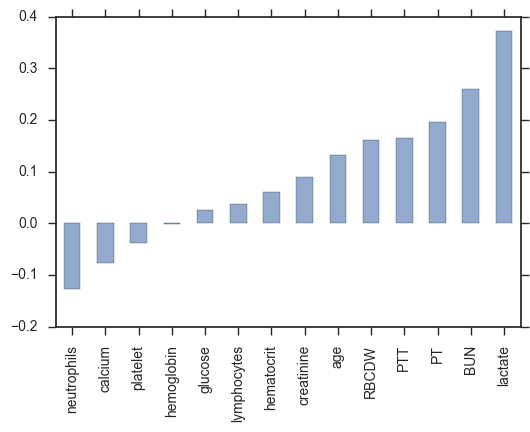

In [51]:
tst = correlation_df['death_period']
tst = tst.drop('death_period')
tst.sort_values(inplace=True)
tst.plot(kind='bar', alpha=0.6)

A very interesting view of correlation to mortality can be seen here. From my previous study, platelet count, glucose levels, and creatinine are strongly correlated with the survivability of a septic condition. Here we can see, that isn't necessarily true. Lactate levels, as suspected, are strongly correlated, however. Why is this? Lactate levels in the blood indicate anaerobic cellular respiration this means that cells are producing lactic acid instead of respiring normally, producing CO2. The production of lactic acid means cells are not receiving oxygen, a sign of septic shock. This is promising. While BUN is not highly correlated with mortality, it is somewhat useful. BUN indicates blood urea nitrogen levels. This is an indication that the kidneys are not properly filtering urea from the blood. This is a good indication of organ dysfunction.

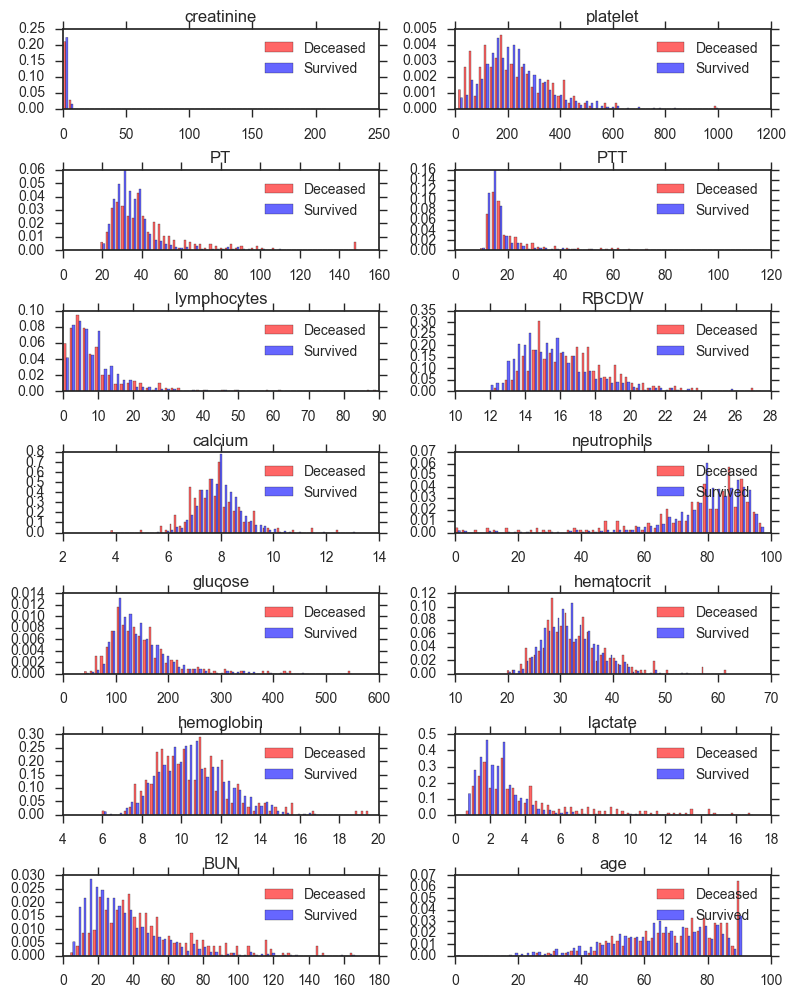

In [58]:
vital_columns_cp = vital_columns[:]
vital_columns_cp.remove('death_period')
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(8,10))
axes = axes.ravel()
for idx,axis in enumerate(axes):
    axis.figure
    
    binwidth= (max(vitals_only[vital_columns_cp[idx]]) - min(vitals_only[vital_columns_cp[idx]]))/50
    bins = 50
    axis.hist([neg[vital_columns_cp[idx]],pos[vital_columns_cp[idx]]], bins=bins, alpha=0.6, normed=True, label=['Deceased','Survived'], color=['red','blue'])
    axis.legend(loc='upper right')
    axis.set_title(vital_columns_cp[idx])
plt.tight_layout()

Again, nothing jumps out as a red flag clearly indicating survivability here, but there are some useful trends within each feature. There appears to be a slight indication of mortality with low platelet counts. The extended positive tail associated with mortality on PT, PTT, RBCDW, lactate, and BUN are useful. The negative increasing tail associated with mortality in neutrophils is also a useful feature.

While I would have been happy seeing several strongly correlated features, this is promising information. Next, let us conduct principal component analysis to further look at how features interact.

## Principal Component Analysis


In [67]:
from sklearn.decomposition import PCA

def pca_explain(observables):
    pca = PCA(n_components=3)
    pca.fit(observables)

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # Individual PCA Components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = observables.keys())
    components.index = dimensions

    # Explained variance in PCA
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    print(pd.concat([variance_ratios, components], axis = 1))

In [71]:
observables = vitals_only
observables = observables.drop('death_period', 1)

pca_explain(observables)

             Explained Variance  creatinine  platelet      PT     PTT  \
Dimension 1              0.7704      0.0002   -0.9995  0.0104  0.0007   
Dimension 2              0.1523     -0.0001   -0.0023 -0.0042 -0.0044   
Dimension 3              0.0313      0.0527   -0.0030  0.0423  0.0599   

             lymphocytes   RBCDW  calcium  neutrophils  glucose  hematocrit  \
Dimension 1       0.0082 -0.0002  -0.0010      -0.0265  -0.0024      0.0036   
Dimension 2       0.0095 -0.0051   0.0006      -0.0091   0.9972      0.0144   
Dimension 3      -0.0458  0.0174   0.0015       0.0646  -0.0672     -0.0231   

             hemoglobin  lactate     BUN     age  
Dimension 1      0.0022   0.0030  0.0002 -0.0072  
Dimension 2      0.0044   0.0041  0.0643  0.0302  
Dimension 3     -0.0118   0.0078  0.9617  0.2348  


This PCA breakdown gives a good indication of how features are correlated and explain variance. Platelets appear to have little correlation to other features, this can be seen by its high negative weight in dimension 1 and low weights for most other features except a neutrophils. Let's look at the correlational graph to platelets.

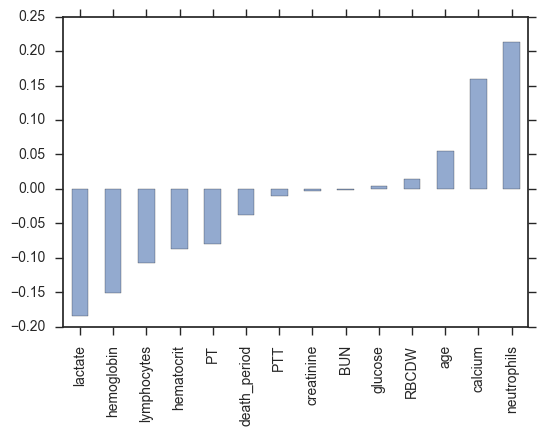

In [62]:
tst = correlation_df['platelet']
tst = tst.drop('platelet')
tst.sort_values(inplace=True)
tst.plot(kind='bar', alpha=0.6)

In dimension 2, glucose is heavily weighted, so let us look at the correlation graph to glucose to see if there is anything interesting.

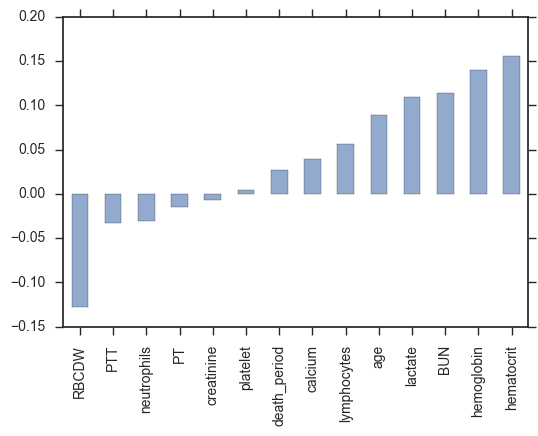

In [63]:
tst = correlation_df['glucose']
tst = tst.drop('glucose')
tst.sort_values(inplace=True)
tst.plot(kind='bar', alpha=0.6)

This PCA analysis gives a better understanding of how the data explains variance. There isn't a strong correlation between glucose and platelet counts therefore they have strong weights in separate dimensions. Unfortunately platelet counts and clucose are not very useful in indicating the survivability of sepsis so lets see what the dimensions look like without the features that do not aid in explaining survivability.

In [72]:
observables = observables.drop(['platelet','hemoglobin', 'lymphocytes', 'glucose'], 1)

pca_explain(observables)

             Explained Variance  creatinine      PT     PTT   RBCDW  calcium  \
Dimension 1              0.4282      0.0515  0.0380  0.0565  0.0155   0.0017   
Dimension 2              0.1839      0.0158  0.8376  0.1945  0.0167  -0.0070   
Dimension 3              0.1553      0.0470 -0.3568 -0.0657 -0.0002   0.0024   

             neutrophils  hematocrit  lactate     BUN     age  
Dimension 1       0.0520     -0.0181   0.0089  0.9646  0.2429  
Dimension 2      -0.3589     -0.0041   0.0419  0.0626 -0.3543  
Dimension 3       0.0606     -0.0191  -0.0081  0.2378 -0.8975  


Now we can see that the variance is not easily explained by three dimensions due to the lack of correlation between all of the features.

## Microbiology Events
We have seen how some basic vitals play a role in correlation with mortality. It may be that certain types of infection also have a strong correlation to mortality as well. Here a 24 hour reading of infection will be obtained, with zero, one, or multiple types of infection. It will be encoded properly and visualized.

In [147]:
# Beautiful query /sarcasm
bio_event_query = session.query(BioEvent).filter(BioEvent.hadm_id.in_(patient_hadm_ids)).filter(BioEvent.org_name != None)

# print bio_event_query
bio_events = pd.read_sql(bio_event_query.statement, bio_event_query.session.bind).groupby('hadm_id')

In [148]:
# Prepare joining copy of patient vitals
patient_bio = patient_info[['hadm_id']].copy()
patient_bio['infection'] = np.nan
patient_bio['num_infections'] = 0
patient_bio.infection = patient_bio.infection.astype(object)
    
patient_bio = patient_bio.set_index('hadm_id')

In [149]:
infection_types = set()

# Obtain each unique infection and throw into a set for multilabelbinerizer
for hadm_id, group in bio_events:
    admittance_time = patient_info.loc[patient_info.hadm_id==hadm_id]['admittime'].values[0]
    day_results = group[((group.charttime - admittance_time) < one_day)]
    infections = tuple(day_results.org_name.unique())
    infection_types.update(infections)

    patient_bio.set_value(hadm_id, 'infection', infections)
    patient_bio.set_value(hadm_id, 'num_infections', len(infections))

for row in patient_bio.loc[patient_bio.infection.isnull(), 'infection'].index:
    patient_bio.at[row, 'infection'] = tuple()
    

In [151]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
bio_matrix = mlb.fit_transform(patient_bio['infection'])

feature_df = pd.DataFrame(data=bio_matrix, columns=mlb.classes_,  index=patient_bio.index)
multi_bio = pd.concat([feature_df, patient_bio], axis=1)

In [156]:
multi_bio = multi_bio.drop('infection', 1)

In [157]:
# New patient info dataframe finally with vitals
multi_bio = vital_patient_info.join(multi_bio, on='hadm_id')

pos = multi_bio[multi_bio['death_period'] == 0]
neg = multi_bio[multi_bio['death_period'] == 1]

Now that we have successfully appended infection type in a "multi-hot" encoded format, we can look into several useful features. First let us see how the number of arbitrary infections correlates with the mortality rate of individuals with sepsis.

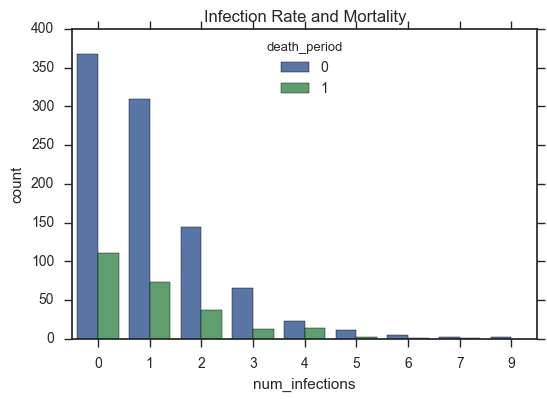

In [159]:
ax = plt.axes()
sns.countplot(x="num_infections", hue="death_period", data=multi_bio, ax=ax)
ax.set_title('Infection Rate and Mortality')

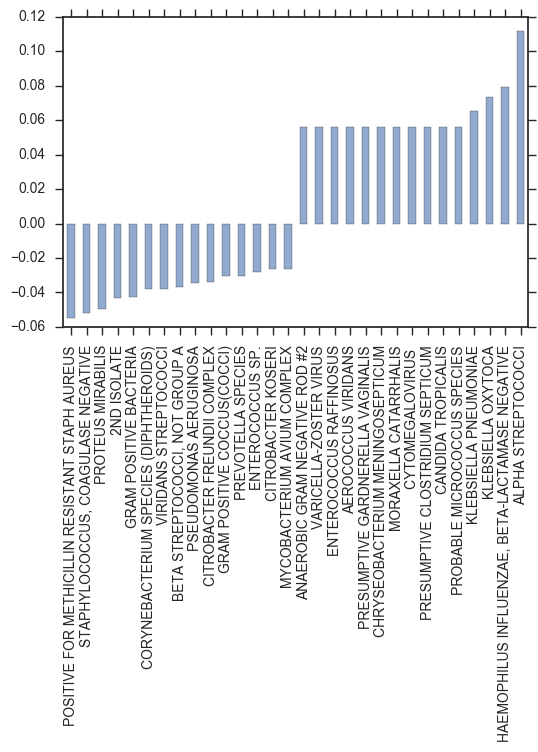

In [190]:
correlation_df = multi_bio.corr().copy()
plt.rcParams.update({'font.size': 2})
tst = correlation_df['death_period']
tst = tst[mlb.classes_]
tst.sort_values(inplace=True)
tst_condensed = tst[:15]
tst_condensed = tst_condensed.append( tst[-15:])
tst_condensed.plot(kind='bar', alpha=0.6)

In [200]:
y = multi_bio['death_period']
X = multi_bio.drop(['death_period', 'subject_id', 'hadm_id', 'admittime', 'ethnicity', 'dob'], 1)
X = pd.get_dummies(X)
print X.columns

Index([                     u'age',               u'creatinine',
                       u'platelet',                       u'PT',
                            u'PTT',              u'lymphocytes',
                          u'RBCDW',                  u'calcium',
                    u'neutrophils',                  u'glucose',
       ...
                 u'num_infections', u'admission_type_EMERGENCY',
          u'admission_type_URGENT',     u'insurance_Government',
             u'insurance_Medicaid',       u'insurance_Medicare',
              u'insurance_Private',       u'insurance_Self Pay',
                       u'gender_F',                 u'gender_M'],
      dtype='object', length=126)


In [201]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import RandomizedSearchCV

stump_clf =  DecisionTreeClassifier(random_state=42, max_depth=1)

param_grid = {
              "base_estimator__max_features": ['auto', 'sqrt', 'log2'],
              "n_estimators": list(range(1,500)),
              "learning_rate": np.linspace(0.01, 1, num=20),
             }

ada_clf = AdaBoostClassifier(base_estimator = stump_clf)

rand_ada = RandomizedSearchCV(ada_clf, param_grid, scoring = 'accuracy', n_iter=100, random_state=42)
rand_ada.fit(X,y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,...68,  0.89579,
        0.94789,  1.     ]), 'base_estimator__max_features': ['auto', 'sqrt', 'log2']},
          pre_dispatch='2*n_jobs', random_state=42, refit=

In [202]:
print(rand_ada.best_score_)
print(rand_ada.best_params_)
print(rand_ada.best_estimator_)

0.809121621622
{'n_estimators': 17, 'learning_rate': 0.32263157894736844, 'base_estimator__max_features': 'sqrt'}
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=0.32263157894736844, n_estimators=17,
          random_state=None)


In [206]:
# 

y = vital_patient_info['death_period']
X = vital_patient_info.drop(['death_period', 'subject_id', 'hadm_id', 'admittime', 'ethnicity', 'dob'], 1)
X = pd.get_dummies(X)

In [207]:
rand_ada = RandomizedSearchCV(ada_clf, param_grid, scoring = 'accuracy', n_iter=100, random_state=42)
rand_ada.fit(X,y)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,...68,  0.89579,
        0.94789,  1.     ]), 'base_estimator__max_features': ['auto', 'sqrt', 'log2']},
          pre_dispatch='2*n_jobs', random_state=42, refit=

In [208]:
print(rand_ada.best_score_)
print(rand_ada.best_params_)
print(rand_ada.best_estimator_)

0.822635135135
{'n_estimators': 89, 'learning_rate': 0.16631578947368422, 'base_estimator__max_features': 'auto'}
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
          learning_rate=0.16631578947368422, n_estimators=89,
          random_state=None)
